<a href="https://www.kaggle.com/code/abdullahathar/giki-rsna-cancer-detection?scriptVersionId=118216750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# %%capture
# ! pip install timm
# ! pip install einops
# ! pip install --upgrade wandb
# ! pip install --upgrade torchmetrics
# ! pip install --upgrade pytorch-lightning

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pydicom
import glob
from pathlib import Path

import os, sys
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

import wandb

import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset,DataLoader
import cv2
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision.transforms as transforms


# Section 1: Data

In [4]:
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

image_path  = Path('/kaggle/input/rsna-breast-cancer-256-pngs')

path = []
for i in tqdm(range(len(df))):
    row = df.iloc[i, :]
    filename = str(row.patient_id) + "_" + str(row.image_id) + ".png"
    path.append(image_path /  filename )
df["path"] = path


  0%|          | 0/54706 [00:00<?, ?it/s]

In [5]:
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-256-pngs/1000...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-256-pngs/1000...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-256-pngs/1000...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-breast-cancer-256-pngs/1000...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-breast-cancer-256-pngs/1001...


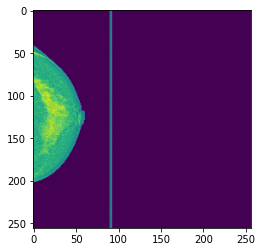

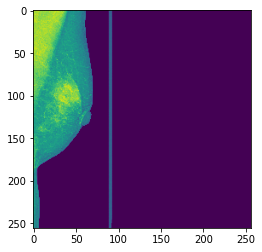

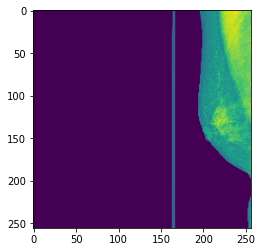

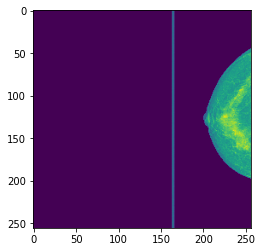

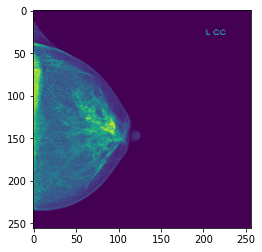

In [7]:
# let's view the first two training instances
for i in range(5):
    img_read = cv2.imread(str(df["path"][i]), cv2.IMREAD_UNCHANGED)
    plt.imshow(img_read)
    plt.show()



In [8]:
img_read.shape

(256, 256)

0    53548
1     1158
Name: cancer, dtype: int64


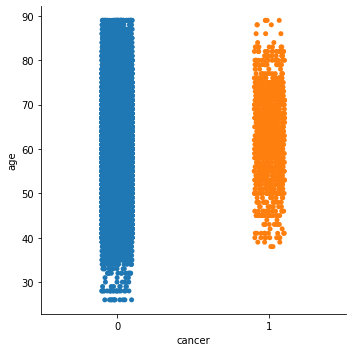

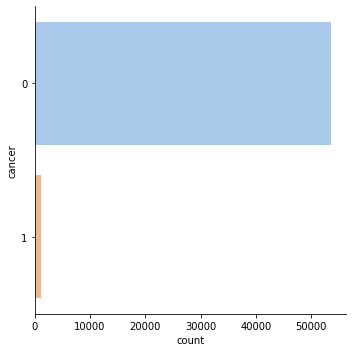

In [9]:
sns.catplot(data = df, x = "cancer", y = "age", order = [0,1])

sns.catplot(data = df, y = "cancer", kind = "count", 
           palette = "pastel")

print(df.cancer.value_counts())

## Logging using WandB

In [14]:
# Config = {}

In [15]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wb_key = user_secrets.get_secret("wandb")

# wandb.login(key=wb_key)

# run = wandb.init(
#     project='pytorch_lightning',
#     config=Config,
#     group='GIKI',
#     job_type='train',
# )

# Section 2: Modelling 

## Loss Function

In [10]:
def probabilistic_f1(labels, preds, beta=1):
    """
    Function taken from Awsaf's notebook:
    https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train
    """
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

## Splitting up Data

In [11]:
X = df["path"].astype(str)
y = df["cancer"]

def split(X,y,stage):

    x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                        test_size = 0.25,
                                                       random_state = 42, 
                                                       stratify = y)

    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, 
                                                    test_size = 0.25, random_state = 42,
                                                   stratify = y_test)

    if stage in "train":
        return(x_train.reset_index(drop = True), y_train.reset_index(drop = True))
    if stage in "test":
        return(x_test.reset_index(drop = True), y_test.reset_index(drop = True))
    if stage in "val":
        return(x_val.reset_index(drop = True), y_val.reset_index(drop = True))
    if stage in "predict":
        return(x_test.reset_index(drop = True))




## Creating pytorch dataset

In [18]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, image, targets, stage):
        
        if stage == "train":
            image, targets = split(image, targets, "train")
            self.image  = image
            self.targets = targets
        elif stage == "test":
            image, targets = split(image, targets, "test")
            self.image  = image
            self.targets = targets
        elif stage == "val":
            image, targets = split(image, targets, "val")
            self.image  = image
            self.targets = targets
        elif stage == "predict":
            image = split(image, targets, "predict")
            self.image  = image
            self.targets = None
        else:
            raise ValueError(f"stage :{stage} not in [train, test, val, predict]" )
    def __len__(self):
        return len(self.image)
    def __getitem__(self, index):
        path = self.image[index]
        image = cv2.imread(path)
        #image = cv2.resize(image, (256,256))
        #image = transformations(image)
        if self.targets is None:
            return torch.tensor(image).float().reshape(3,256,256)
        return torch.tensor(image).float().reshape(3,256,256), torch.tensor(self.targets[index])

Pytorch lightning data module 

In [19]:
class CancerDataModule(pl.LightningDataModule):
    def __init__(self, X,y, batch_size, num_workers):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def setup(self,stage:str):
        self.train_dataset = CancerDataset(self.X,self.y,stage = "train")
        self.test_dataset = CancerDataset(self.X,self.y, stage = "test")
        self.val_dataset = CancerDataset(self.X,self.y, stage = "val")
        self.predict_dataset = CancerDataset(self.X,self.y,stage = "predict")
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle = True, 
                          batch_size=self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          batch_size=self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          batch_size=self.batch_size, num_workers = self.num_workers)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, 
                          batch_size=self.batch_size, num_workers = self.num_workers)

## Resnet50 Model 

In [14]:
nn = torchvision.models.resnet50(pretrained=True)
nn.fc = torch.nn.Linear(2048,2) # changing num output features

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [20]:
criterion = torch.nn.CrossEntropyLoss()

class CancerModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.nn = nn
    def forward(self,x):
        return self.nn(x)
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                    lr = 1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size = 20,
                                                   gamma = 0.75,
                                                   last_epoch = -1, 
                                                   verbose = True)
        return {"optimizer": optimizer,
               "lr_scheduler": {
                   "scheduler": scheduler,
                   "monitor" : "val_loss"
                   },
               }
    
    def training_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = criterion(y_pred, y)
        return loss
    def validation_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = criterion(y_pred, y)
        self.log("val_loss", loss)
        return loss
    def test_step(self, batch, batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = criterion(y_pred, y)
        self.log("test_loss: ", loss)
        return loss
    
    

## Trainer

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor = "val_loss",
                                     mode = "min")

model = CancerModel()
data = CancerDataModule(X,y, batch_size = 32, num_workers = 1)
trainer = pl.Trainer(max_epochs = 10, 
                    accelerator = "gpu", 
                     devices = 1, 
                    callbacks = [checkpoint_callback],
                    )
trainer.fit(model, data)


Adjusting learning rate of group 0 to 1.0000e-04.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]